# Part 1: Time Series Data Summarization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Interface to facilitate calculation of Euclidean distance, RMSE and statistics

In [2]:
# An interface to calculate euclidean distance between 2 signals
def euc_dist(x,y):
    return float(np.linalg.norm(x - y))

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(x,y):
    return sqrt(mean_squared_error(x, y))

def summarize_data(x):
    print("Average:", np.mean(x).round(4), " Mean:", np.median(x).round(4), " Max:", np.max(x).round(4), " Min:", np.min(x).round(4), "\n")

### Load 50k time_series (synthetic and seismic)

In [3]:
import struct
filename_synthetic = 'synthetic_size50k_len256_znorm.bin'
with open(filename_synthetic, 'rb') as in_file:
    time_series_synthetic = np.array(struct.unpack('f' * 50000 * 256, in_file.read())).reshape(-1,256)

filename_seismic = 'seismic_size50k_len256_znorm.bin'
with open(filename_seismic, 'rb') as in_file:
    time_series_seismic = np.array(struct.unpack('f' * 50000 * 256, in_file.read())).reshape(-1,256)

# Compression with float32

In [4]:
def compress_to_size(x, size):
    size = int(size/4 /2)
    piece_size = int(256/size)
    com_x = np.array([], dtype = np.float32).reshape(50000, -1)
    for i in range(size):
        sum_segment = np.sum(x[:, int(piece_size*i):int(piece_size*i+piece_size-1)], axis = 1)
        abssum_segment = np.sum(np.square(x[:, int(piece_size*i):int(piece_size*i+piece_size-1)]), axis = 1)
        com_x = np.column_stack((com_x, sum_segment))
        com_x = np.column_stack((com_x, abssum_segment))
    return com_x
def decompress1024(x, size):
    size = int(size/4 /2)
    piece_size = int(256/size)
    rec_x = np.array([], dtype = np.float32).reshape(50000, -1)
    for i in range(size):
        deviationSegment = x[:, 2*i] / piece_size
        deviationPoint = np.sqrt(x[:, 2*i+1] / piece_size)
        for j in range(int(piece_size/2)):
            m1 = deviationSegment + deviationPoint
            m2 = deviationSegment - deviationPoint
            rec_x = np.column_stack((rec_x, m1))
            rec_x = np.column_stack((rec_x, m2))
    return rec_x

## 50k synthetic time_series (float32)

In [5]:
# Following code is to compress and reconstruct synthetic data

x = time_series_synthetic

com_128 = compress_to_size(x, 128)
com_64 = compress_to_size(x, 64)
com_32 = compress_to_size(x, 32)

reconstructed_128 = decompress1024(com_128, 128)
reconstructed_64 = decompress1024(com_64, 64)
reconstructed_32 = decompress1024(com_32, 32)

# Initialize variables to record reconstruction error for 50k time_series
errorList_128_synthetic_float32 = []
errorList_64_synthetic_float32 = []
errorList_32_synthetic_float32 = []

data_size = 50000
for i in range(data_size):
    x = time_series_synthetic[i,]
    errorList_128_synthetic_float32.append(rmse(x, reconstructed_128[i,]))
    errorList_64_synthetic_float32.append(rmse(x, reconstructed_64[i,]))
    errorList_32_synthetic_float32.append(rmse(x, reconstructed_32[i,]))

## 50k seismic time_series (float32)

In [6]:
# Following code is to compress and reconstruct seismic data

x = time_series_seismic

com_128 = compress_to_size(x, 128)
com_64 = compress_to_size(x, 64)
com_32 = compress_to_size(x, 32)

reconstructed_128 = decompress1024(com_128, 128)
reconstructed_64 = decompress1024(com_64, 64)
reconstructed_32 = decompress1024(com_32, 32)

# Initialize variables to record reconstruction error for 50k time_series
errorList_128_seismic_float32 = []
errorList_64_seismic_float32 = []
errorList_32_seismic_float32 = []

data_size = 50000
for i in range(data_size):
    x = time_series_seismic[i,]
    errorList_128_seismic_float32.append(rmse(x, reconstructed_128[i,]))
    errorList_64_seismic_float32.append(rmse(x, reconstructed_64[i,]))
    errorList_32_seismic_float32.append(rmse(x, reconstructed_32[i,]))

# Compression with int8

In [7]:
def compress_to_size(x, size):
    size = int(size/2)
    piece_size = int(256/size)
    com_x = np.array([], dtype = np.float32).reshape(50000, -1)
    for i in range(size):
        sum_segment = np.sum(x[:, int(piece_size*i):int(piece_size*i+piece_size-1)], axis = 1)
        abssum_segment = np.sum(np.square(x[:, int(piece_size*i):int(piece_size*i+piece_size-1)]), axis = 1)
        com_x = np.column_stack((com_x, sum_segment))
        com_x = np.column_stack((com_x, abssum_segment))
    return com_x
def decompress1024(x, size):
    size = int(size/2)
    piece_size = int(256/size)
    rec_x = np.array([], dtype = np.float32).reshape(50000, -1)
    for i in range(size):
        deviationSegment = x[:, 2*i] / piece_size
        deviationPoint = np.sqrt(x[:, 2*i+1] / piece_size)
        for j in range(int(piece_size/2)):
            m1 = deviationSegment + deviationPoint
            m2 = deviationSegment - deviationPoint
            rec_x = np.column_stack((rec_x, m1))
            rec_x = np.column_stack((rec_x, m2))
    return rec_x

## 50k synthetic time_series (int8)

In [8]:
# Following code is to compress and reconstruct synthetic data

x = time_series_synthetic

com_128 = compress_to_size(x, 128)
com_64 = compress_to_size(x, 64)
com_32 = compress_to_size(x, 32)

scale_n_128 = 127 / max(abs(np.amax(com_128)), abs(np.amin(com_128)))
com_128 = np.multiply(com_128, scale_n_128).round().astype(np.int8)
com_128 = np.multiply(com_128, 1/scale_n_128).astype(np.float32)

scale_n_64 = 127 / max(abs(np.amax(com_64)), abs(np.amin(com_64)))
com_64 = np.multiply(com_64, scale_n_64).round().astype(np.int8)
com_64 = np.multiply(com_64, 1/scale_n_64).astype(np.float32)

scale_n_32 = 127 / max(abs(np.amax(com_32)), abs(np.amin(com_32)))
com_32 = np.multiply(com_32, scale_n_32).round().astype(np.int8)
com_32 = np.multiply(com_32, 1/scale_n_32).astype(np.float32)

reconstructed_128 = decompress1024(com_128, 128)
reconstructed_64 = decompress1024(com_64, 64)
reconstructed_32 = decompress1024(com_32, 32)

# Initialize variables to record reconstruction error for 50k time_series
errorList_128_synthetic_int8 = []
errorList_64_synthetic_int8 = []
errorList_32_synthetic_int8 = []

data_size = 50000
for i in range(data_size):
    x = time_series_synthetic[i,]
    errorList_128_synthetic_int8.append(rmse(x, reconstructed_128[i,]))
    errorList_64_synthetic_int8.append(rmse(x, reconstructed_64[i,]))
    errorList_32_synthetic_int8.append(rmse(x, reconstructed_32[i,]))

## 50k seismic time_series (int8)

In [9]:
# Following code is to compress and reconstruct seismic data

x = time_series_seismic

com_128 = compress_to_size(x, 128)
com_64 = compress_to_size(x, 64)
com_32 = compress_to_size(x, 32)

scale_n_128 = 127 / max(abs(np.amax(com_128)), abs(np.amin(com_128)))
com_128 = np.multiply(com_128, scale_n_128).round().astype(np.int8)
com_128 = np.multiply(com_128, 1/scale_n_128).astype(np.float32)

scale_n_64 = 127 / max(abs(np.amax(com_64)), abs(np.amin(com_64)))
com_64 = np.multiply(com_64, scale_n_64).round().astype(np.int8)
com_64 = np.multiply(com_64, 1/scale_n_64).astype(np.float32)

scale_n_32 = 127 / max(abs(np.amax(com_32)), abs(np.amin(com_32)))
com_32 = np.multiply(com_32, scale_n_32).round().astype(np.int8)
com_32 = np.multiply(com_32, 1/scale_n_32).astype(np.float32)

reconstructed_128 = decompress1024(com_128, 128)
reconstructed_64 = decompress1024(com_64, 64)
reconstructed_32 = decompress1024(com_32, 32)

# Initialize variables to record reconstruction error for 50k time_series
errorList_128_seismic_int8 = []
errorList_64_seismic_int8 = []
errorList_32_seismic_int8 = []

data_size = 50000
for i in range(data_size):
    x = time_series_seismic[i,]
    errorList_128_seismic_int8.append(rmse(x, reconstructed_128[i,]))
    errorList_64_seismic_int8.append(rmse(x, reconstructed_64[i,]))
    errorList_32_seismic_int8.append(rmse(x, reconstructed_32[i,]))

## Error evaluation

In [10]:
# Reconstruction error for 50k synthetic time_series
print("RMSE of 50k synthetic time series: 128 -> 1024 (float32)")
summarize_data(errorList_128_synthetic_float32)
print("RMSE of 50k synthetic time series: 64 -> 1024 (float32)")
summarize_data(errorList_64_synthetic_float32)
print("RMSE of 50k synthetic time series: 32 -> 1024 (float32)")
summarize_data(errorList_32_synthetic_float32)

print("RMSE of 50k synthetic time series: 128 -> 1024 (int8)")
summarize_data(errorList_128_synthetic_int8)
print("RMSE of 50k synthetic time series: 64 -> 1024 (int8)")
summarize_data(errorList_64_synthetic_int8)
print("RMSE of 50k synthetic time series: 32 -> 1024 (int8)")
summarize_data(errorList_32_synthetic_int8)


# Reconstruction error for 50k seismic time_series
print("RMSE of 50k seismic time series: 128 -> 1024 (float32)")
summarize_data(errorList_128_seismic_float32)
print("RMSE of 50k seismic time series: 64 -> 1024 (float32)")
summarize_data(errorList_64_seismic_float32)
print("RMSE of 50k seismic time series: 32 -> 1024 (float32)")
summarize_data(errorList_32_seismic_float32)

print("RMSE of 50k seismic time series: 128 -> 1024 (int8)")
summarize_data(errorList_128_seismic_int8)
print("RMSE of 50k seismic time series: 64 -> 1024 (int8)")
summarize_data(errorList_64_seismic_int8)
print("RMSE of 50k seismic time series: 32 -> 1024 (int8)")
summarize_data(errorList_32_seismic_int8)

RMSE of 50k synthetic time series: 128 -> 1024 (float32)
Average: 1.0222  Mean: 1.0132  Max: 1.2865  Min: 0.9627 

RMSE of 50k synthetic time series: 64 -> 1024 (float32)
Average: 1.0797  Mean: 1.0663  Max: 1.4019  Min: 0.9843 

RMSE of 50k synthetic time series: 32 -> 1024 (float32)
Average: 1.1586  Mean: 1.143  Max: 1.4257  Min: 1.0019 

RMSE of 50k synthetic time series: 128 -> 1024 (int8)
Average: 0.915  Mean: 0.9125  Max: 1.0307  Min: 0.8687 

RMSE of 50k synthetic time series: 64 -> 1024 (int8)
Average: 0.9713  Mean: 0.9662  Max: 1.1533  Min: 0.9242 

RMSE of 50k synthetic time series: 32 -> 1024 (int8)
Average: 1.0224  Mean: 1.0136  Max: 1.2857  Min: 0.9566 

RMSE of 50k seismic time series: 128 -> 1024 (float32)
Average: 1.3909  Mean: 1.3913  Max: 1.5503  Min: 1.2759 

RMSE of 50k seismic time series: 64 -> 1024 (float32)
Average: 1.4025  Mean: 1.4029  Max: 1.5165  Min: 1.32 

RMSE of 50k seismic time series: 32 -> 1024 (float32)
Average: 1.4083  Mean: 1.4087  Max: 1.4893  Min:

## Visualize reconstruction errors of 50k time series with Boxplot

In [11]:
plt.rcParams['figure.figsize'] = [12, 6]

<function matplotlib.pyplot.show(*args, **kw)>

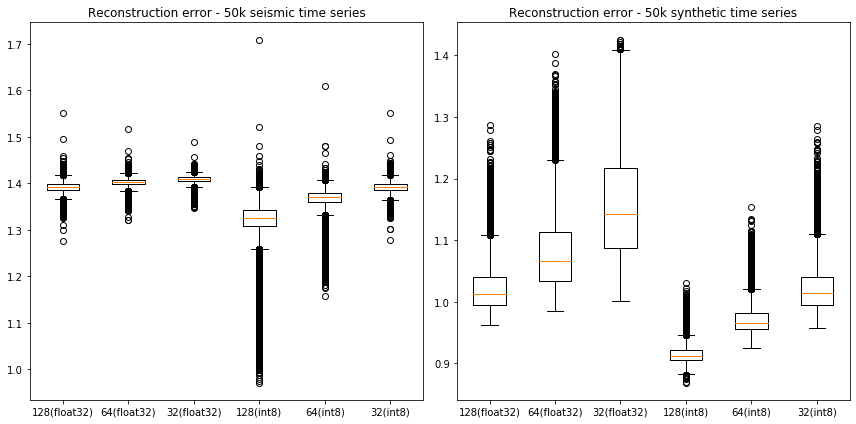

In [12]:
plt.subplot(1,2,1)
plt.boxplot([errorList_128_seismic_float32, errorList_64_seismic_float32, errorList_32_seismic_float32, 
             errorList_128_seismic_int8, errorList_64_seismic_int8, errorList_32_seismic_int8])
plt.title('Reconstruction error - 50k seismic time series')
plt.xticks([1, 2, 3, 4, 5, 6], ['128(float32)', '64(float32)', '32(float32)', '128(int8)', '64(int8)', '32(int8)'])

plt.subplot(1,2,2)
plt.boxplot([errorList_128_synthetic_float32, errorList_64_synthetic_float32, errorList_32_synthetic_float32, 
             errorList_128_synthetic_int8, errorList_64_synthetic_int8, errorList_32_synthetic_int8])
plt.title('Reconstruction error - 50k synthetic time series')
plt.xticks([1, 2, 3, 4, 5, 6], ['128(float32)', '64(float32)', '32(float32)', '128(int8)', '64(int8)', '32(int8)'])

plt.tight_layout()
plt.show

In [15]:
import numpy as np
errorFolder = "./errors/"
errorTag = "_Sum&SquareSum"

np.save(errorFolder + "128_seismic" + errorTag + "_float32", errorList_128_seismic_float32)
np.save(errorFolder + "64_seismic" + errorTag + "_float32", errorList_64_seismic_float32)
np.save(errorFolder + "32_seismic" + errorTag + "_float32", errorList_32_seismic_float32)
np.save(errorFolder + "128_seismic" + errorTag + "_int8", errorList_128_seismic_int8)
np.save(errorFolder + "64_seismic" + errorTag + "_int8", errorList_64_seismic_int8)
np.save(errorFolder + "32_seismic" + errorTag + "_int8", errorList_32_seismic_int8)

np.save(errorFolder + "128_synthetic" + errorTag + "_float32", errorList_128_synthetic_float32)
np.save(errorFolder + "64_synthetic" + errorTag + "_float32", errorList_64_synthetic_float32)
np.save(errorFolder + "32_synthetic" + errorTag + "_float32", errorList_32_synthetic_float32)
np.save(errorFolder + "128_synthetic" + errorTag + "_int8", errorList_128_synthetic_int8)
np.save(errorFolder + "64_synthetic" + errorTag + "_int8", errorList_64_synthetic_int8)
np.save(errorFolder + "32_synthetic" + errorTag + "_int8", errorList_32_synthetic_int8)

In [14]:
#tmp = np.load(errorFolder + "128_seismic" + errorTag + "_float32" + ".npy")
#tmp.shape